<a href="https://colab.research.google.com/github/meti-94/TextClassification/blob/main/FinRL_StockTrading_NeurIPS_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: BTC Trading

* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)   
* [RLlib Section](#7)            

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of BTC" or "Sell 10 shares of BTC" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: BTC/USD


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git -q

     |████████████████████████████████| 234 kB 8.3 MB/s 
     |████████████████████████████████| 176 kB 44.0 MB/s 
     |████████████████████████████████| 57.6 MB 1.3 MB/s 
     |████████████████████████████████| 1.8 MB 36.9 MB/s 
     |████████████████████████████████| 124 kB 48.9 MB/s 
     |████████████████████████████████| 147 kB 42.6 MB/s 
     |████████████████████████████████| 45 kB 2.5 MB/s 
     |████████████████████████████████| 2.4 MB 29.1 MB/s 
     |████████████████████████████████| 153 kB 45.2 MB/s 
     |████████████████████████████████| 195 kB 47.5 MB/s 
     |████████████████████████████████| 90.8 MB 286 bytes/s 
     |████████████████████████████████| 448 kB 42.9 MB/s 
     |████████████████████████████████| 52 kB 1.3 MB/s 
     |████████████████████████████████| 3.6 MB 32.5 MB/s 
     |████████████████████████████████| 1.1 MB 42.3 MB/s 
     |████████████████████████████████| 271 kB 46.6 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████

In [2]:
from finrl.apps import config
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.4'></a>
## 2.4. Create Folders

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [4]:
# from config.py start_date is a string
config.START_DATE = '2015-01-01'
config.START_DATE

'2015-01-01'

In [5]:
# from config.py end_date is a string
config.END_DATE = '2022-01-01'
config.END_DATE

'2022-01-01'

In [7]:
config.DOW_30_TICKER = ['BTC']
config.DOW_30_TICKER

['BTC']

In [8]:
df = YahooDownloader(start_date = config.START_DATE,
                     end_date = config.END_DATE,
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (316, 8)


In [9]:
print(config.DOW_30_TICKER)

['BTC']


In [10]:
df.shape

(316, 8)

In [78]:
df.sort_values(['date','tic'],ignore_index=True).head(30)

,date,open,high,low,close,volume,tic,day
0,2020-10-01,100.000000,100.000000,100.000000,100.000000,0,BTC,3
1,2020-10-02,100.000000,100.000000,100.000000,100.000000,0,BTC,4
2,2020-10-05,100.029999,100.040001,99.995003,99.995003,10725,BTC,0
3,2020-10-06,100.010002,100.029999,100.010002,100.029999,10080,BTC,1
4,2020-10-07,99.949997,99.959999,99.919998,99.919998,6350,BTC,2
5,2020-10-08,99.989998,99.995003,99.971703,99.995003,650,BTC,3
6,2020-10-09,99.970001,99.980003,99.940002,99.940002,1820,BTC,4
7,2020-10-12,99.959999,99.970001,99.940002,99.940002,5685,BTC,0
8,2020-10-13,99.978996,99.989998,99.963203,99.964996,3635,BTC,1
9,2020-10-14,100.000000,100.000000,99.974998,99.974998,3985,BTC,2


In [ ]:
!pip install kaggle -q
import os
os.environ['KAGGLE_CONFIG_DIR']='/content/drive/MyDrive/kaggle_dataset'
%cd /content/drive/MyDrive/kaggle_dataset
!kaggle datasets download -d mczielinski/bitcoin-historical-data
!unzip bitcoin-historical-data.zip

In [79]:
from datetime import datetime
hist = pd.read_csv('/content/drive/MyDrive/kaggle_dataset/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv', parse_dates=True)
hist = hist[hist.Timestamp>=1388521800]
hist['date'] = hist['Timestamp'].apply(lambda item:datetime.fromtimestamp(item))
hist.rename(columns={'Open':'open', 'High':'high', 'Close':'close', 'Low':'low', 'Volume_(BTC)':'volume'}, inplace=True)
hist['tic'] = ['BTC' for _ in range(len(hist))]
hist['day'] = [i%5 for i in range(len(hist))]
hist = hist[df.columns]


In [81]:
df = hist

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [ ]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

In [13]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [14]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-10-01,BTC,100.000000,100.000000,100.000000,100.000000,0.0,3.0,0.000000,100.000000,100.000000,0.000000,100.000000,100.000000,100.000000,100.000000,26.700001,0.0
1,2020-10-02,BTC,100.000000,100.000000,100.000000,100.000000,0.0,4.0,0.000000,100.000000,100.000000,0.000000,100.000000,100.000000,100.000000,100.000000,27.629999,0.0
2,2020-10-05,BTC,100.029999,100.040001,99.995003,99.995003,10725.0,0.0,-0.000155,100.004105,99.992564,0.000000,100.000000,100.000000,99.998334,99.998334,27.959999,0.0
3,2020-10-06,BTC,100.010002,100.029999,100.010002,100.029999,10080.0,1.0,0.001042,100.038264,99.974237,87.870758,119.987794,100.000000,100.006250,100.006250,29.480000,0.0
4,2020-10-07,BTC,99.949997,99.959999,99.919998,99.919998,6350.0,2.0,-0.002707,100.070977,99.907023,22.780843,-166.666667,43.994861,99.989000,99.989000,28.059999,0.0
5,2020-10-08,BTC,99.989998,99.995003,99.971703,99.995003,650.0,3.0,-0.001702,100.063486,99.916515,49.281301,-15.862178,10.823436,99.990000,99.990000,26.360001,0.0
6,2020-10-09,BTC,99.970001,99.980003,99.940002,99.940002,1820.0,4.0,-0.003520,100.059855,99.905860,39.101815,-89.788199,27.084480,99.982858,99.982858,25.000000,0.0
7,2020-10-12,BTC,99.959999,99.970001,99.940002,99.940002,5685.0,0.0,-0.004683,100.054960,99.900042,39.101815,-78.092111,27.084480,99.977501,99.977501,25.070000,0.0
8,2020-10-13,BTC,99.978996,99.989998,99.963203,99.964996,3635.0,1.0,-0.004176,100.049046,99.903177,44.660759,-21.843787,12.321201,99.976112,99.976112,26.070000,0.0
9,2020-10-14,BTC,100.000000,100.000000,99.974998,99.974998,3985.0,2.0,-0.003241,100.044767,99.907233,46.675846,5.755978,5.752489,99.976000,99.976000,26.400000,0.0


In [17]:
processed_full.sort_values(['date','tic'],ignore_index=True).tail(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
305,2021-12-16,BTC,98.630997,98.651199,98.624496,98.651199,597.0,3.0,-0.031589,98.823904,98.209387,48.451460,22.130374,11.548687,98.591614,98.716725,20.570000,4.003227
306,2021-12-17,BTC,98.639999,98.639999,98.639999,98.639999,54.0,4.0,-0.022061,98.830657,98.208633,48.270819,27.020065,11.548687,98.582610,98.705814,21.570000,0.003015
307,2021-12-20,BTC,98.644997,98.644997,98.644997,98.644997,48.0,0.0,-0.013946,98.835469,98.207821,48.359685,40.720953,11.833926,98.567110,98.696730,22.870001,0.009082
308,2021-12-21,BTC,98.500000,98.500000,98.500000,98.500000,199.0,1.0,-0.018996,98.824170,98.242120,45.988320,-33.421181,1.665184,98.552943,98.685397,21.010000,1.679122
309,2021-12-22,BTC,98.591797,98.591797,98.591797,98.591797,2.0,2.0,-0.015414,98.791148,98.317072,47.668933,34.024683,7.365514,98.537203,98.679177,18.629999,0.813934
310,2021-12-23,BTC,98.529999,98.541702,98.529999,98.541702,505.0,3.0,-0.016427,98.733801,98.410090,46.846048,1.593573,3.066004,98.531927,98.671790,17.959999,0.168955
311,2021-12-27,BTC,98.540001,98.550003,98.269997,98.550003,2513.0,0.0,-0.016372,98.733841,98.410250,47.002870,-51.311661,12.663516,98.530760,98.663957,17.680000,0.016618
312,2021-12-28,BTC,98.610001,98.610001,98.589996,98.589996,160.0,1.0,-0.012952,98.735248,98.411343,47.770896,46.532456,8.576047,98.529283,98.654124,17.540001,0.178874
313,2021-12-29,BTC,98.470001,98.485001,98.470001,98.485001,402.0,2.0,-0.018500,98.728812,98.402228,45.961933,-33.721745,15.156888,98.528547,98.643040,16.950001,0.841080
314,2021-12-30,BTC,98.609497,98.609497,98.609497,98.609497,83.0,3.0,-0.012705,98.728463,98.402256,48.360527,52.416954,6.643310,98.533863,98.635448,17.330000,1.455805


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of BTC" or "Sell 10 shares of BTC" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2020-07-01
## Trade data split: 2020-07-01 to 2021-10-31

In [18]:
train = data_split(processed_full, '2015-01-01','2021-07-01')
trade = data_split(processed_full, '2021-07-01','2022-01-01')
print(len(train))
print(len(trade))

188
127


In [19]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
183,2021-06-24,BTC,99.110001,99.110001,99.110001,99.110001,0.0,3.0,0.013224,99.110001,99.11,51.90912,-34.482759,45.311351,99.110001,99.010904,15.97,0.0
184,2021-06-25,BTC,99.110001,99.110001,99.110001,99.110001,0.0,4.0,0.012282,99.110001,99.11,51.90912,-34.482759,45.311351,99.110001,99.020827,15.62,0.0
185,2021-06-28,BTC,99.110001,99.110001,99.110001,99.110001,0.0,0.0,0.011404,99.110001,99.11,51.90912,-34.482759,45.311351,99.110001,99.028577,15.76,0.0
186,2021-06-29,BTC,99.110001,99.110001,99.110001,99.110001,0.0,1.0,0.010586,99.110001,99.11,51.90912,-34.482759,45.311351,99.110001,99.038357,16.02,0.0
187,2021-06-30,BTC,99.110001,99.110001,99.110001,99.110001,0.0,2.0,0.009825,99.110001,99.11,51.90912,-34.482759,45.311351,99.110001,99.045009,15.83,0.0


In [20]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2021-07-01,BTC,99.110001,99.110001,99.110001,99.110001,0.0,3.0,0.009117,99.110001,99.11,51.90912,-34.482759,45.311351,99.110001,99.051482,15.480000,0.0
1,2021-07-02,BTC,99.110001,99.110001,99.110001,99.110001,0.0,4.0,0.008458,99.110001,99.11,51.90912,-34.482759,45.311351,99.110001,99.056399,15.070000,0.0
2,2021-07-06,BTC,99.110001,99.110001,99.110001,99.110001,0.0,1.0,0.007845,99.110001,99.11,51.90912,-34.482759,45.311351,99.110001,99.062304,16.440001,0.0
3,2021-07-07,BTC,99.110001,99.110001,99.110001,99.110001,0.0,2.0,0.007276,99.110001,99.11,51.90912,-34.482759,45.311351,99.110001,99.068984,16.200001,0.0
4,2021-07-08,BTC,99.110001,99.110001,99.110001,99.110001,0.0,3.0,0.006747,99.110001,99.11,51.90912,-34.482759,45.311351,99.110001,99.073769,19.000000,0.0


In [21]:
config.TECHNICAL_INDICATORS_LIST

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [22]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 1, State Space: 11


In [23]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment for Training



In [24]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [25]:
agent = DRLAgent(env = env_train)

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 1: A2C


In [26]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


In [27]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

------------------------------------------
| time/                 |                |
|    fps                | 137            |
|    iterations         | 100            |
|    time_elapsed       | 3              |
|    total_timesteps    | 500            |
| train/                |                |
|    entropy_loss       | -1.46          |
|    explained_variance | 0              |
|    learning_rate      | 0.0007         |
|    n_updates          | 99             |
|    policy_loss        | 0.024          |
|    reward             | -6.4144355e-05 |
|    std                | 1.05           |
|    value_loss         | 0.000352       |
------------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 176          |
|    iterations         | 200          |
|    time_elapsed       | 5            |
|    total_timesteps    | 1000         |
| train/                |              |
|    entropy_loss       |

### Model 2: DDPG

In [28]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device


In [29]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

day: 187, episode: 270
begin_total_asset: 1000000.00
end_total_asset: 1000000.00
total_reward: 0.00
total_cost: 0.00
total_trades: 0
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 102      |
|    time_elapsed    | 7        |
|    total_timesteps | 752      |
| train/             |          |
|    actor_loss      | 3.43e+03 |
|    critic_loss     | 5.85e+04 |
|    learning_rate   | 0.001    |
|    n_updates       | 564      |
|    reward          | 0.0      |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 90       |
|    time_elapsed    | 16       |
|    total_timesteps | 1504     |
| train/             |          |
|    actor_loss      | 3.24e+03 |
|    critic_loss     | 6.31e+04 |
|    learning_rate   | 0.001    |
|    n_updates       | 1316     |
|    reward          | 0.0      |
-----------------

### Model 3: PPO

In [30]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [31]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000)

day: 187, episode: 540
begin_total_asset: 1000000.00
end_total_asset: 999105.36
total_reward: -894.64
total_cost: 1153.15
total_trades: 182
Sharpe: -1.066
-----------------------------------
| time/              |            |
|    fps             | 383        |
|    iterations      | 1          |
|    time_elapsed    | 5          |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | -0.0009911 |
-----------------------------------
day: 187, episode: 550
begin_total_asset: 1000000.00
end_total_asset: 999310.41
total_reward: -689.59
total_cost: 864.96
total_trades: 165
Sharpe: -4.132
------------------------------------------
| time/                   |              |
|    fps                  | 342          |
|    iterations           | 2            |
|    time_elapsed         | 11           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0027368967 |
|    clip_fraction     

### Model 4: TD3

In [32]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device


In [33]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000)

day: 187, episode: 810
begin_total_asset: 1000000.00
end_total_asset: 991627.41
total_reward: -8372.59
total_cost: 998.97
total_trades: 187
Sharpe: -0.878
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 110       |
|    time_elapsed    | 6         |
|    total_timesteps | 752       |
| train/             |           |
|    actor_loss      | -6.48e+03 |
|    critic_loss     | 1.01e+04  |
|    learning_rate   | 0.001     |
|    n_updates       | 564       |
|    reward          | 0.0       |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 96        |
|    time_elapsed    | 15        |
|    total_timesteps | 1504      |
| train/             |           |
|    actor_loss      | -4.85e+03 |
|    critic_loss     | 7.86e+03  |
|    learning_rate   | 0.001     |
|    n_updates       | 1316      |
|    

### Model 5: SAC

In [34]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [35]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=60000)

day: 187, episode: 970
begin_total_asset: 1000000.00
end_total_asset: 1000000.00
total_reward: 0.00
total_cost: 0.00
total_trades: 0
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 55        |
|    time_elapsed    | 13        |
|    total_timesteps | 752       |
| train/             |           |
|    actor_loss      | -2.02e+04 |
|    critic_loss     | 1.17e+05  |
|    ent_coef        | 0.107     |
|    ent_coef_loss   | 20.8      |
|    learning_rate   | 0.0001    |
|    n_updates       | 651       |
|    reward          | 0.0       |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 51        |
|    time_elapsed    | 29        |
|    total_timesteps | 1504      |
| train/             |           |
|    actor_loss      | -1.81e+04 |
|    critic_loss     | 4.1e+05   |
|    ent_coef        | 0.11

## Trading
Assume that we have $1,000,000 initial capital at 2021-07-01. We use the DDPG model to trade BTC stocks.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [36]:
data_risk_indicator = processed_full[(processed_full.date<'2021-07-01') & (processed_full.date>='2015-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [37]:
insample_risk_indicator.vix.describe()

count    188.000000
mean      22.282660
std        4.775455
min       15.620000
25%       18.662500
50%       21.605000
75%       24.420000
max       40.279999
Name: vix, dtype: float64

In [38]:
insample_risk_indicator.vix.quantile(0.996)

38.589520034790056

In [39]:
insample_risk_indicator.turbulence.describe()

count    188.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: turbulence, dtype: float64

In [40]:
insample_risk_indicator.turbulence.quantile(0.996)

0.0

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [41]:
#trade = data_split(processed_full, '2020-07-01','2021-10-31')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [42]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2021-07-01,BTC,99.110001,99.110001,99.110001,99.110001,0.0,3.0,0.009117,99.110001,99.11,51.90912,-34.482759,45.311351,99.110001,99.051482,15.480000,0.0
1,2021-07-02,BTC,99.110001,99.110001,99.110001,99.110001,0.0,4.0,0.008458,99.110001,99.11,51.90912,-34.482759,45.311351,99.110001,99.056399,15.070000,0.0
2,2021-07-06,BTC,99.110001,99.110001,99.110001,99.110001,0.0,1.0,0.007845,99.110001,99.11,51.90912,-34.482759,45.311351,99.110001,99.062304,16.440001,0.0
3,2021-07-07,BTC,99.110001,99.110001,99.110001,99.110001,0.0,2.0,0.007276,99.110001,99.11,51.90912,-34.482759,45.311351,99.110001,99.068984,16.200001,0.0
4,2021-07-08,BTC,99.110001,99.110001,99.110001,99.110001,0.0,3.0,0.006747,99.110001,99.11,51.90912,-34.482759,45.311351,99.110001,99.073769,19.000000,0.0


In [43]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym)

hit end!


In [44]:
df_account_value.shape

(127, 2)

In [45]:
df_account_value.tail()

,date,account_value
122,2021-12-23,1000000.0
123,2021-12-27,1000000.0
124,2021-12-28,1000000.0
125,2021-12-29,1000000.0
126,2021-12-30,1000000.0


In [46]:
df_actions.head()

,date,actions
0,2021-07-01,[0]
1,2021-07-02,[0]
2,2021-07-06,[0]
3,2021-07-07,[0]
4,2021-07-08,[0]


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [47]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.0
Cumulative returns     0.0
Annual volatility      0.0
Sharpe ratio           NaN
Calmar ratio           NaN
Stability              0.0
Max drawdown           0.0
Omega ratio            NaN
Sortino ratio          NaN
Skew                   NaN
Kurtosis               NaN
Tail ratio             NaN
Daily value at risk    0.0
dtype: float64


/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


In [48]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (126, 8)
Annual return          0.109996
Cumulative returns     0.053564
Annual volatility      0.127106
Sharpe ratio           0.890913
Calmar ratio           1.662702
Stability              0.230793
Max drawdown          -0.066155
Omega ratio            1.160425
Sortino ratio          1.253279
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.976871
Daily value at risk   -0.015565
dtype: float64


In [49]:
df_account_value.loc[0,'date']

'2021-07-01'

In [50]:
df_account_value.loc[len(df_account_value)-1,'date']

'2021-12-30'

<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (126, 8)


/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:713: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:799: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/usr/local/lib/python3.7/dist-packages/empyrical/stats.py:1528: RuntimeWarning: invalid value encountered in double_scalars
  np.abs(np.percentile(returns, 5))


Start date,2021-07-01
End date,2021-12-30
Total months,6
,Backtest
Annual return,0.0%
Cumulative returns,0.0%
Annual volatility,0.0%
Sharpe ratio,NaN
Calmar ratio,NaN
Stability,0.00
Max drawdown,0.0%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.00,2021-07-01,2021-07-01,2021-07-01,1
1,NaN,NaT,NaT,NaT,NaN
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


Stress Events,mean,min,max
New Normal,0.00%,0.00%,0.00%


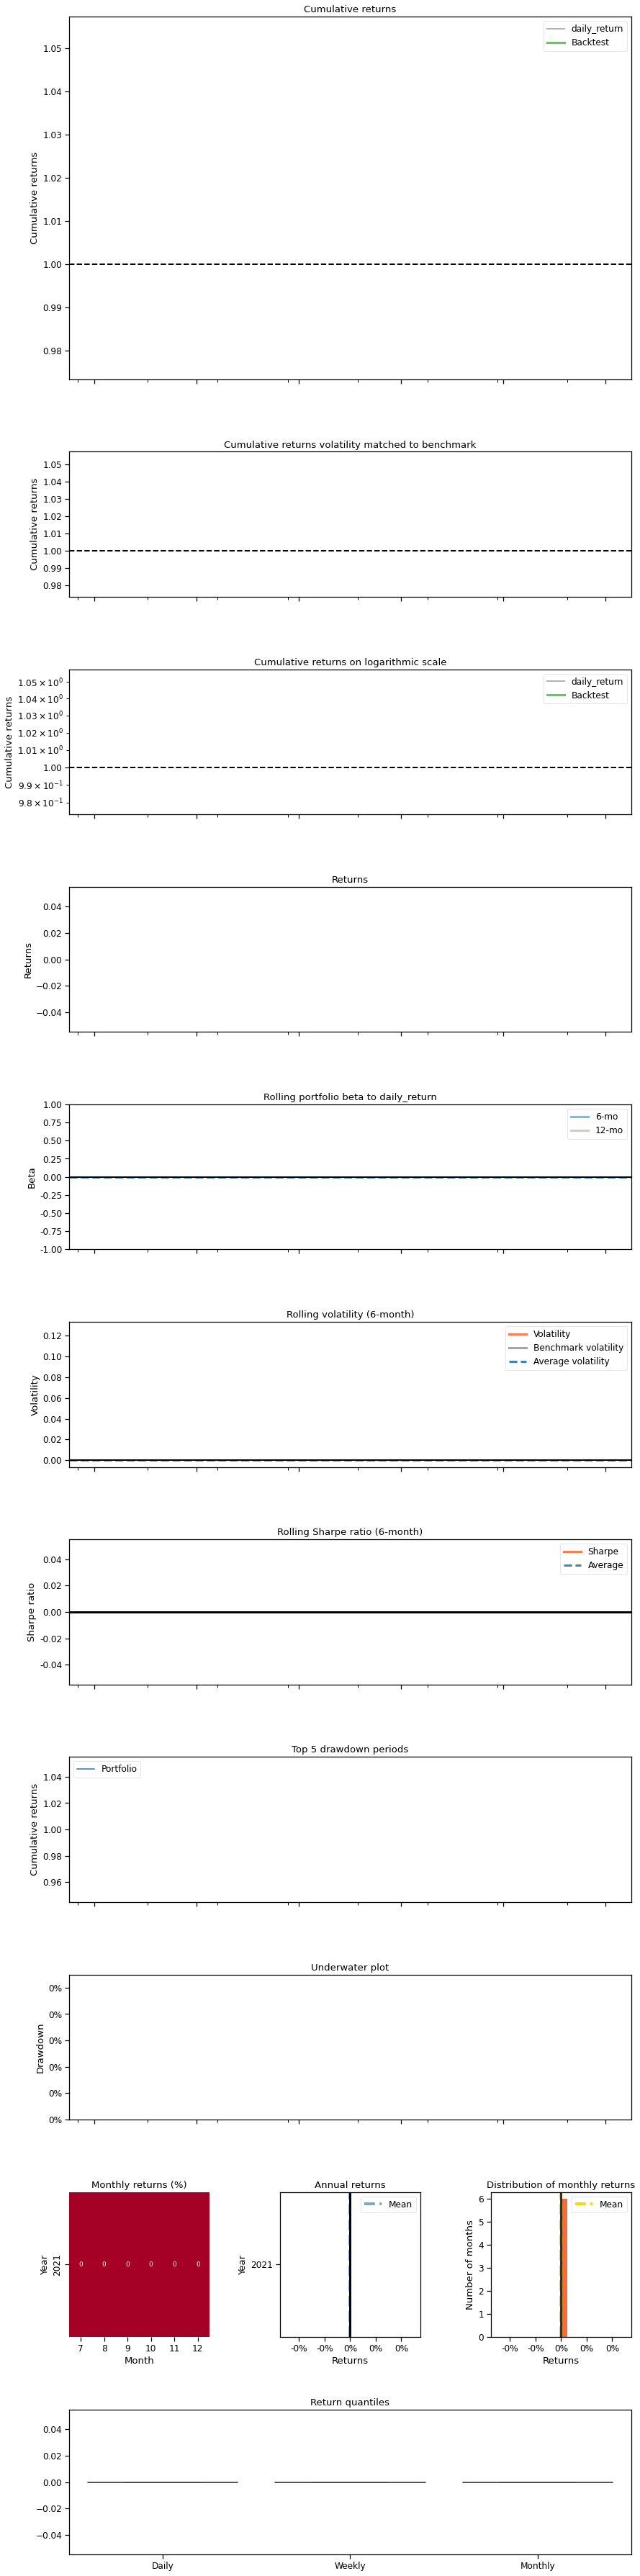

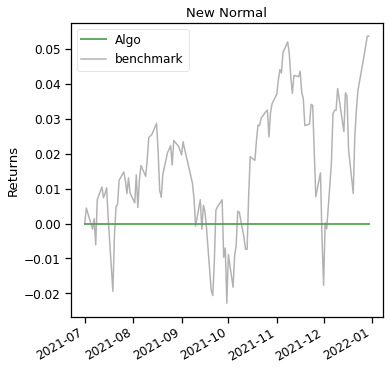

In [51]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])